## Classification
## 0 -> Unhealthy

## 1 -> Healthy

In [1]:
import sys
from pathlib import Path
# Get the repository root (2 levels up from current notebook)
repo_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA
from Mod_Productor2 import Mod_Productor as MP
# Instantiate the Template class


Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

In [2]:
# Lets add the column 'Sana' to all dataframes except df0
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    df.insert(1, 'Sana', df['Tratamiento'].apply(lambda x: 1 if x == 'Control' else 0))
    df.drop(columns=['Tratamiento'], inplace=True)
    # Now if the dataframe have the column 'Planta' delete it
    if 'Planta' in df.columns:
        df.drop(columns=['Planta'], inplace=True)


# lets take 2 samples of each dataframe to use as test data later and put them in the same csv file 
test_samples = []
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    test_sample = df.sample(n=31, random_state=42)
    test_sample.insert(0, 'Day', i)  # Add a column to identify from which sheet they come from
    test_samples.append(test_sample)


# Save all test samples to one CSV file
pd.concat(test_samples, ignore_index=True).to_csv('test_sample_df.csv', index=False)
print("All test samples saved to 'test_sample_df.csv'")

# now remove the sampled rows from the original dataframes taking care to remove the 'Day' column first
for i, (df, test_sample) in enumerate(zip([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], 
                                            test_samples), start=0):
    df_sample = test_sample.drop(columns=['Day'])
    df.drop(df_sample.index, inplace=True)
    


All test samples saved to 'test_sample_df.csv'


In [3]:
# Produce the models for each dataframe
models = {}
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    print(f"Producing model for DataFrame df{i}...")
    modelo = MP(df, target = 'Sana', test_size=0.2, random_state=42, PCA_components=3)
    modelo.train_model()
    models[f'model_df{i}'] = modelo

Producing model for DataFrame df0...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.72714062 0.19268786 0.02838768]
Total explained variance: 0.9482

Class distribution before SMOTE:
  Class 0 (Unhealthy): 150
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unhealthy): 150
  Class 1 (Healthy): 150

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.6600
  Precision: 0.6796
  Recall: 0.7667
  F1-Score: 0.7043
  ROC-AUC: 0.6898
Producing model for DataFrame df1...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.61755556 0.22008315 0.05918535]
Total explained variance: 0.8968

Class distribution before SMOTE:
  Class 0 (Unhealthy): 184
  Class 1 (Healthy): 24

Class distribution after SMOTE:
  Class 0 (Unheal

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'l1_ratio': 0.2, 'penalty': 'elasticnet', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.8694
  Precision: 0.8402
  Recall: 0.9333
  F1-Score: 0.8806
  ROC-AUC: 0.9245
Producing model for DataFrame df11...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.87677177 0.09083452 0.0229204 ]
Total explained variance: 0.9905

Class distribution before SMOTE:
  Class 0 (Unhealthy): 174
  Class 1 (Healthy): 25

Class distribution after SMOTE:
  Class 0 (Unhealthy): 174
  Class 1 (Healthy): 174

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Best scores across all metrics:
  Accuracy: 0.8398
  Precision: 0.7918
  Recall: 0.9714
  F1-Score: 0.8666
  ROC-AUC: 0.8552
Producing model for DataFrame df12...
Original fe

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9161
  Precision: 0.8822
  Recall: 0.9677
  F1-Score: 0.9214
  ROC-AUC: 0.9634
Producing model for DataFrame df14...
Original feature count: 2151
Features after PCA: 3
Explained variance ratio: [0.95931644 0.02790852 0.00804856]
Total explained variance: 0.9953

Class distribution before SMOTE:
  Class 0 (Unhealthy): 153
  Class 1 (Healthy): 25

Class distribution after SMOTE:
  Class 0 (Unhealthy): 153
  Class 1 (Healthy): 153

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.8501
  Precision: 0.8066
  Recall: 0.9804
  F1-Score: 0.8777
  ROC-AUC: 0.8651
Producing model for DataFrame df15...
Original feature count: 2151
Feature

## Big Model

In [4]:
# First make a prediction on the test samples with ALL models and put the results in a csv file

# Concatenate all test samples first
df_predictions = pd.concat(test_samples, ignore_index=True)

# For each model, make predictions on ALL test samples
for model_num in range(0, 16):
    modelo = models[f'model_df{model_num}']
    
    # Prepare all test data (removing 'Sana' and 'Day' columns, keeping only wavelength features)
    feature_columns = [col for col in df_predictions.columns if col not in ['Sana', 'Day'] and not str(col).startswith('pred_')]
    X_test_all = df_predictions[feature_columns].values
    
    # Make predictions with this model on all test samples
    y_pred = modelo.predict(X_test_all)
    
    # Add predictions as a new column
    df_predictions[f'pred_{model_num}'] = y_pred
    print(f"Model {model_num} predictions added to column 'pred_{model_num}'")

# Display the first few rows
print("\nFirst few rows of predictions:")
print(df_predictions.head())

# Save the predictions to a CSV file
df_predictions.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")

# Show column names to verify
print("\nColumns in df_predictions:")
print(df_predictions.columns.tolist())

Model 0 predictions added to column 'pred_0'
Model 1 predictions added to column 'pred_1'
Model 2 predictions added to column 'pred_2'
Model 3 predictions added to column 'pred_3'
Model 4 predictions added to column 'pred_4'
Model 5 predictions added to column 'pred_5'
Model 6 predictions added to column 'pred_6'
Model 7 predictions added to column 'pred_7'
Model 8 predictions added to column 'pred_8'
Model 9 predictions added to column 'pred_9'
Model 10 predictions added to column 'pred_10'
Model 11 predictions added to column 'pred_11'
Model 12 predictions added to column 'pred_12'
Model 13 predictions added to column 'pred_13'
Model 14 predictions added to column 'pred_14'
Model 15 predictions added to column 'pred_15'

First few rows of predictions:
   Day  Sana       350       351       352       353       354       355  \
0    0     1  0.065379  0.063930  0.063162  0.063767  0.063386  0.061034   
1    0     1  0.060442  0.062362  0.056131  0.056657  0.058590  0.058558   
2    0  

In [5]:
# Drop the columns of the wavelength features
df_predictions.drop(columns=feature_columns, inplace=True)

In [6]:
df_predictions.head(10)


,Day,Sana,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15
0,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1
1,0,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1
2,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1
4,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,1,1
5,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
7,0,0,1,0,0,0,1,0,1,0,1,1,1,1,1,1,1,1
8,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1
9,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1


random number healthy: 65 random number unhealthy: 237


C:\Users\ricar\AppData\Local\Temp\ipykernel_18244\2784710968.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


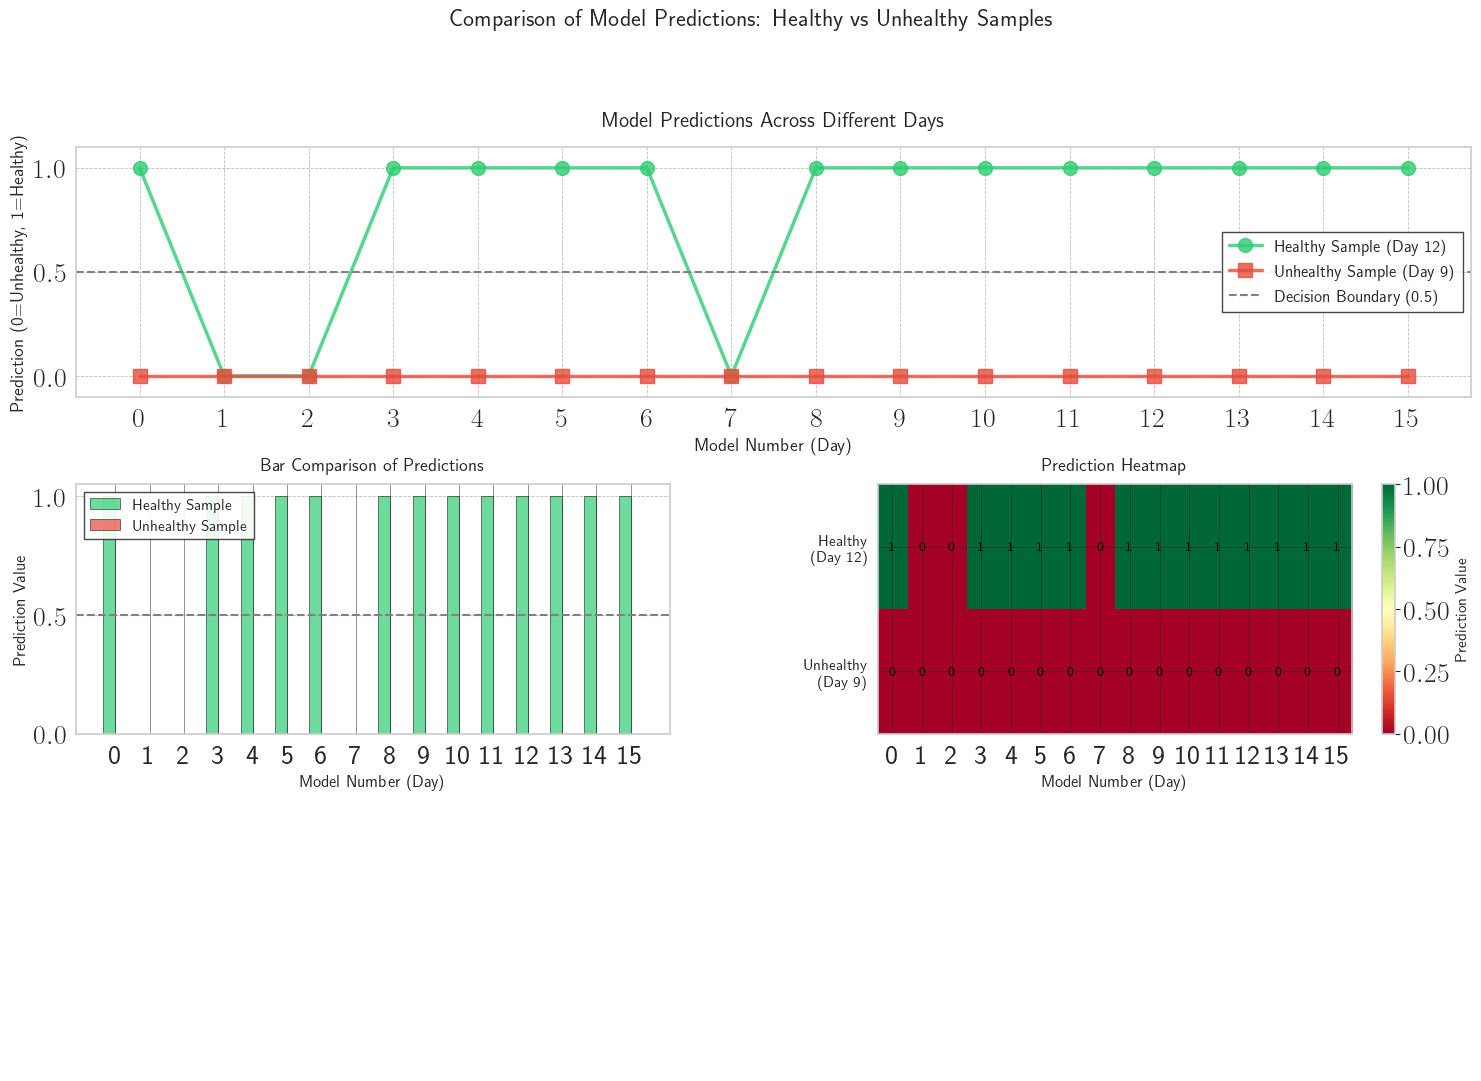

DETAILED PREDICTION SUMMARY

Healthy Sample (Day 12):
  Model  1: 1 Correct
  Model  2: 0 Incorrect
  Model  3: 0 Incorrect
  Model  4: 1 Correct
  Model  5: 1 Correct
  Model  6: 1 Correct
  Model  7: 1 Correct
  Model  8: 0 Incorrect
  Model  9: 1 Correct
  Model 10: 1 Correct
  Model 11: 1 Correct
  Model 12: 1 Correct
  Model 13: 1 Correct
  Model 14: 1 Correct
  Model 15: 1 Correct
  Model 16: 1 Correct

Unhealthy Sample (Day 9):
  Model  1: 0 Correct
  Model  2: 0 Correct
  Model  3: 0 Correct
  Model  4: 0 Correct
  Model  5: 0 Correct
  Model  6: 0 Correct
  Model  7: 0 Correct
  Model  8: 0 Correct
  Model  9: 0 Correct
  Model 10: 0 Correct
  Model 11: 0 Correct
  Model 12: 0 Correct
  Model 13: 0 Correct
  Model 14: 0 Correct
  Model 15: 0 Correct
  Model 16: 0 Correct


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Select one healthy (Sana=1) and one unhealthy (Sana=0) sample
randomnumber = np.random.randint(0, len(df_predictions[df_predictions['Sana'] == 1]))
randomnumber2 = np.random.randint(0, len(df_predictions[df_predictions['Sana'] == 0]))
healthy_sample = df_predictions[df_predictions['Sana'] == 1].iloc[randomnumber]
unhealthy_sample = df_predictions[df_predictions['Sana'] == 0].iloc[randomnumber2]

print(f'random number healthy: {randomnumber} random number unhealthy: {randomnumber2}')

# Extract predictions from each model (pred_0 to pred_15)
model_numbers = list(range(0, 16))
healthy_preds = [healthy_sample[f'pred_{i}'] for i in model_numbers]
unhealthy_preds = [unhealthy_sample[f'pred_{i}'] for i in model_numbers]

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.35)

# 1. Line plot comparing predictions across models
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(model_numbers, healthy_preds, marker='o', linewidth=2.5, markersize=10, 
         label=f'Healthy Sample (Day {int(healthy_sample["Day"])})', color='#2ecc71', alpha=0.8)
ax1.plot(model_numbers, unhealthy_preds, marker='s', linewidth=2.5, markersize=10,
         label=f'Unhealthy Sample (Day {int(unhealthy_sample["Day"])})', color='#e74c3c', alpha=0.8)
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label='Decision Boundary (0.5)')
ax1.set_xlabel('Model Number (Day)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Prediction (0=Unhealthy, 1=Healthy)', fontsize=13, fontweight='bold')
ax1.set_title('Model Predictions Across Different Days', fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(model_numbers)
ax1.set_ylim(-0.1, 1.1)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=12, loc='best')

# 2. Bar chart comparison
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(model_numbers))
width = 0.35
bars1 = ax2.bar(x - width/2, healthy_preds, width, label='Healthy Sample', 
                color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)
bars2 = ax2.bar(x + width/2, unhealthy_preds, width, label='Unhealthy Sample', 
                color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Model Number (Day)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prediction Value', fontsize=12, fontweight='bold')
ax2.set_title('Bar Comparison of Predictions', fontsize=13, fontweight='bold', pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels(model_numbers)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

# 3. Heatmap showing prediction patterns
ax3 = fig.add_subplot(gs[1, 1])
heatmap_data = np.array([healthy_preds, unhealthy_preds])
im = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1, interpolation='nearest')
ax3.set_yticks([0, 1])
ax3.set_yticklabels([f'Healthy\n(Day {int(healthy_sample["Day"])})', 
                      f'Unhealthy\n(Day {int(unhealthy_sample["Day"])})'], fontsize=11)
ax3.set_xticks(range(len(model_numbers)))
ax3.set_xticklabels(model_numbers)
ax3.set_xlabel('Model Number (Day)', fontsize=12, fontweight='bold')
ax3.set_title('Prediction Heatmap', fontsize=13, fontweight='bold', pad=10)

# Add text annotations on heatmap
for i in range(2):
    for j in range(len(model_numbers)):
        color = 'white' if heatmap_data[i, j] == 0.5 else 'black'
        text = ax3.text(j, i, f'{heatmap_data[i, j]:.0f}',
                       ha="center", va="center", color=color, fontsize=10, fontweight='bold')

cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Prediction Value', fontsize=11, fontweight='bold')

# 4. Accuracy statistics
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

# Calculate statistics
healthy_correct = sum(healthy_preds)
unhealthy_correct = len(unhealthy_preds) - sum(unhealthy_preds)
healthy_accuracy = (healthy_correct / len(model_numbers)) * 100
unhealthy_accuracy = (unhealthy_correct / len(model_numbers)) * 100


plt.suptitle('Comparison of Model Predictions: Healthy vs Unhealthy Samples', 
             fontsize=17, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Print summary
print("="*80)
print("DETAILED PREDICTION SUMMARY")
print("="*80)
print(f"\nHealthy Sample (Day {int(healthy_sample['Day'])}):")
for i, pred in enumerate(healthy_preds, 1):
    status = "Correct" if pred == 1 else "Incorrect"
    print(f"  Model {i:2d}: {pred} {status}")

print(f"\nUnhealthy Sample (Day {int(unhealthy_sample['Day'])}):")
for i, pred in enumerate(unhealthy_preds, 1):
    status = "Correct" if pred == 0 else "Incorrect"
    print(f"  Model {i:2d}: {pred} {status}")

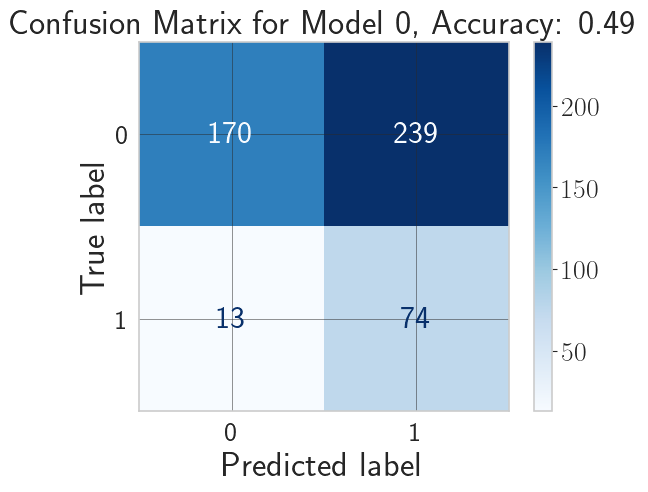

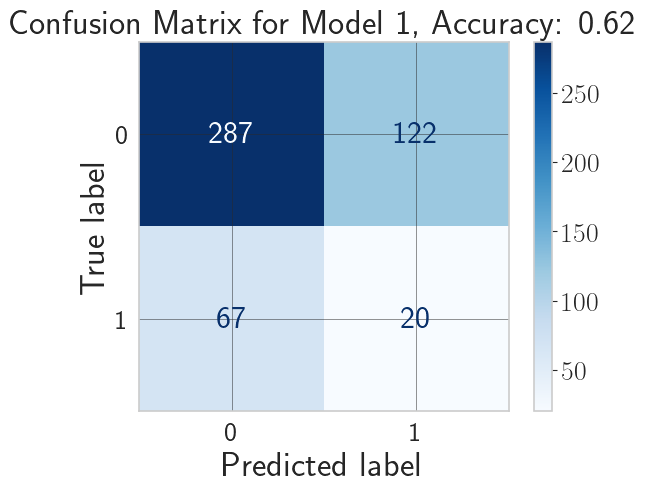

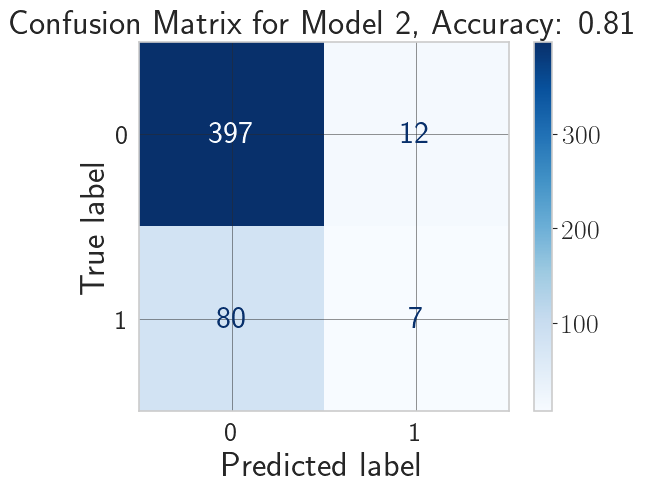

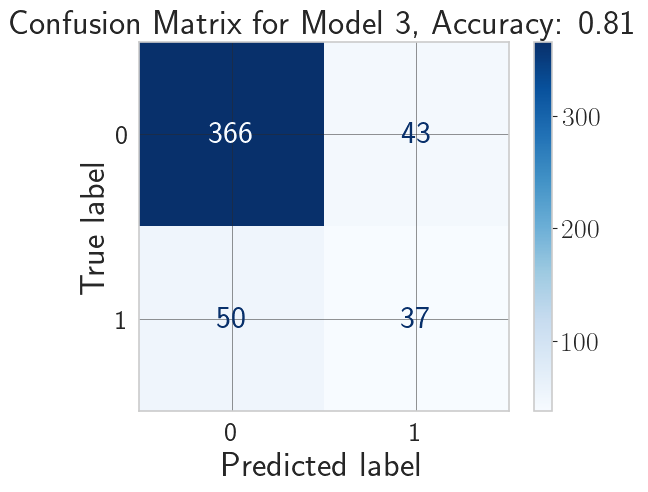

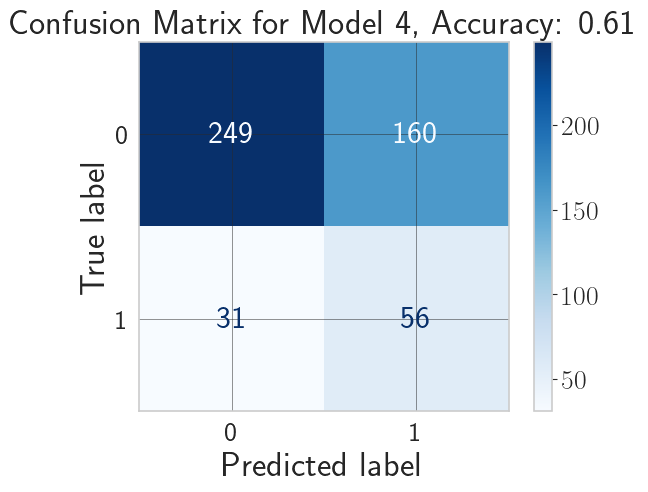

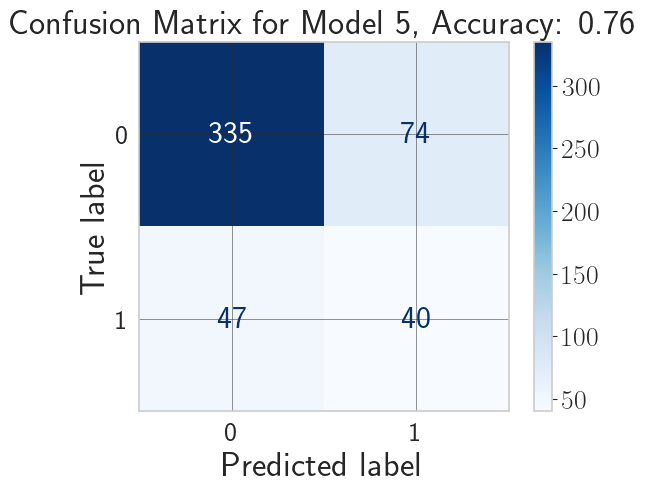

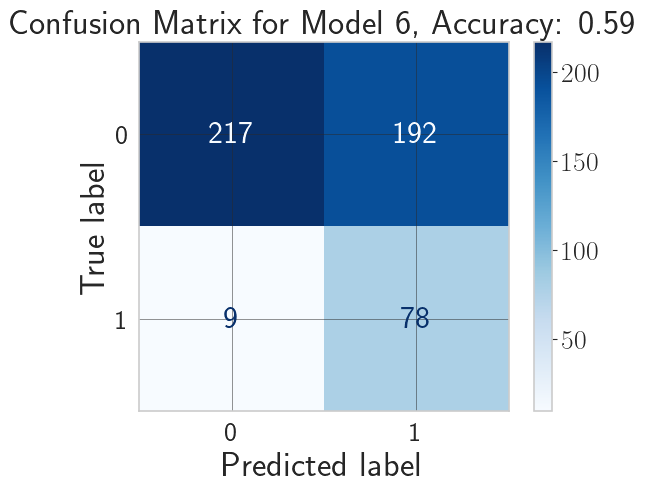

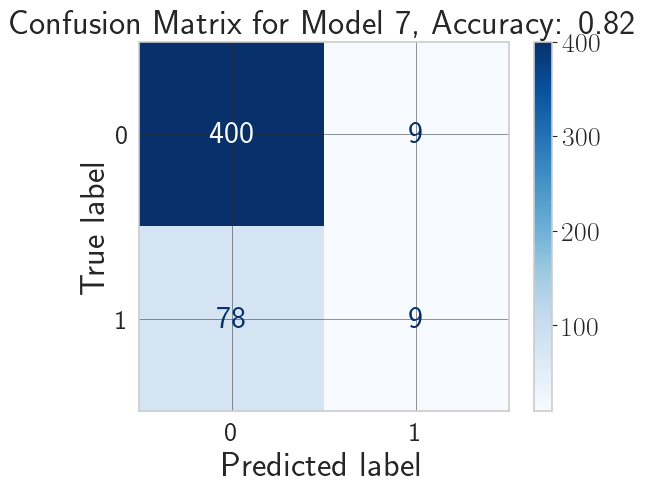

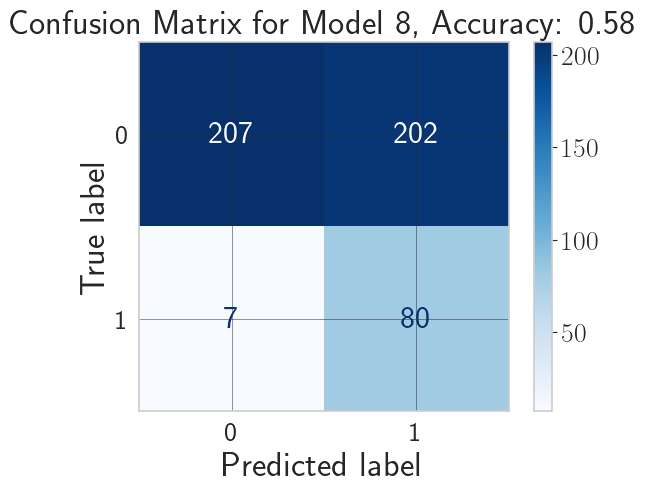

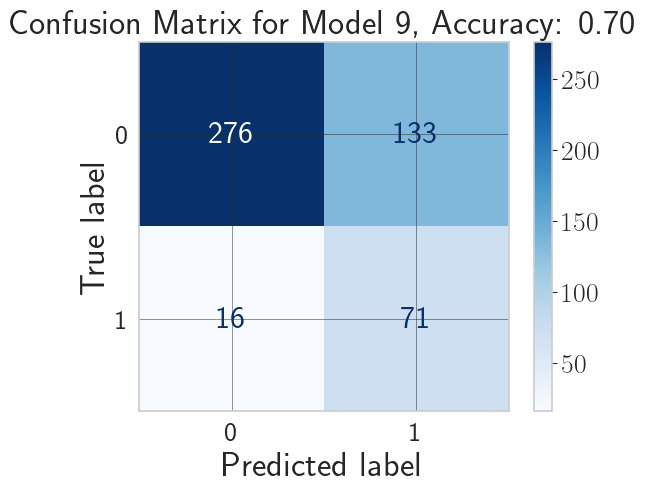

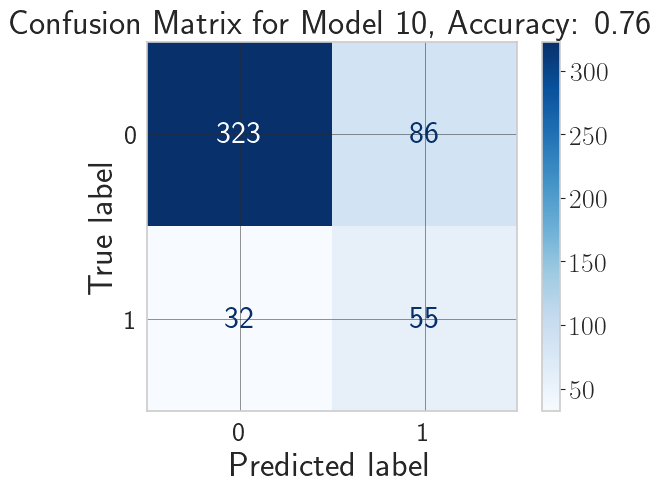

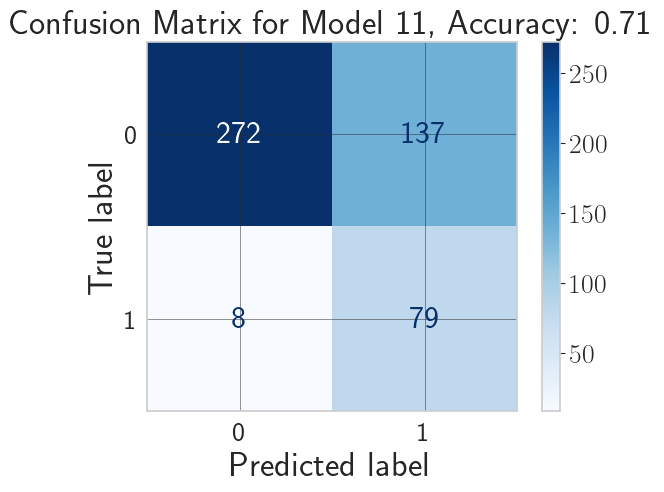

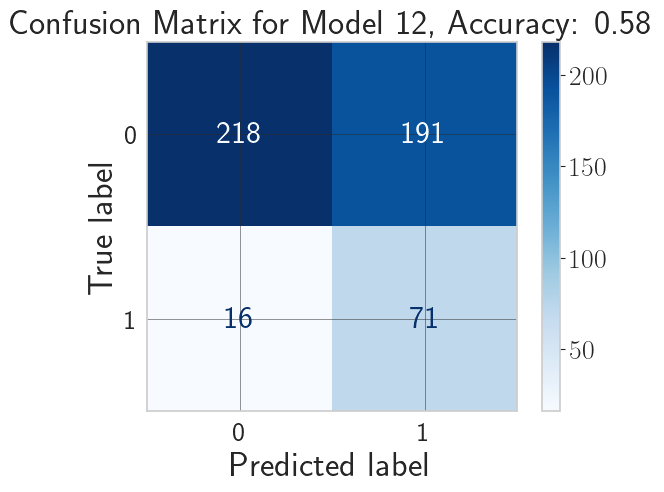

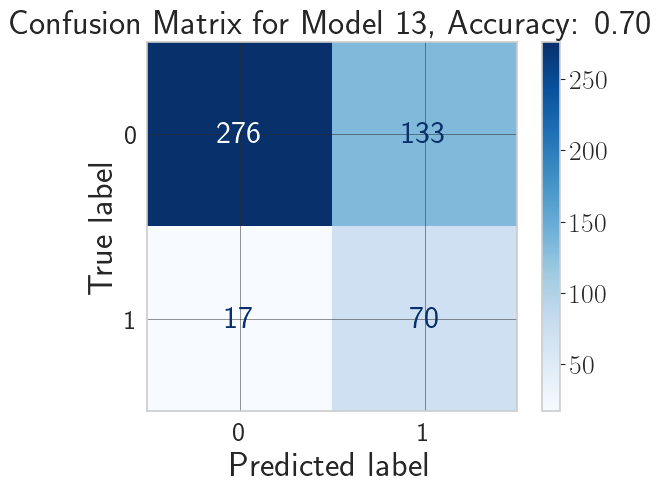

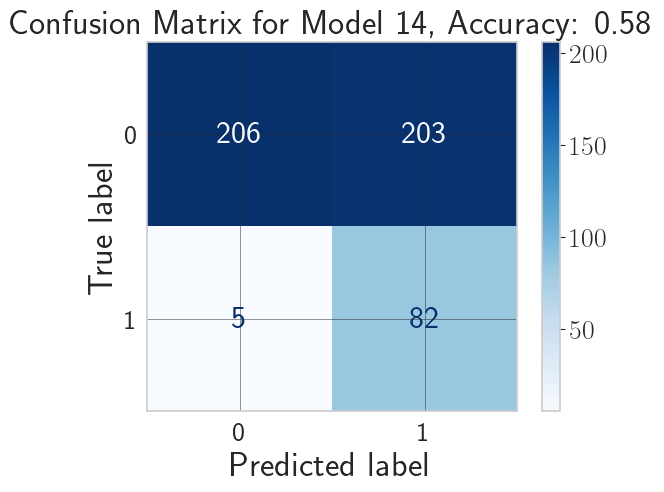

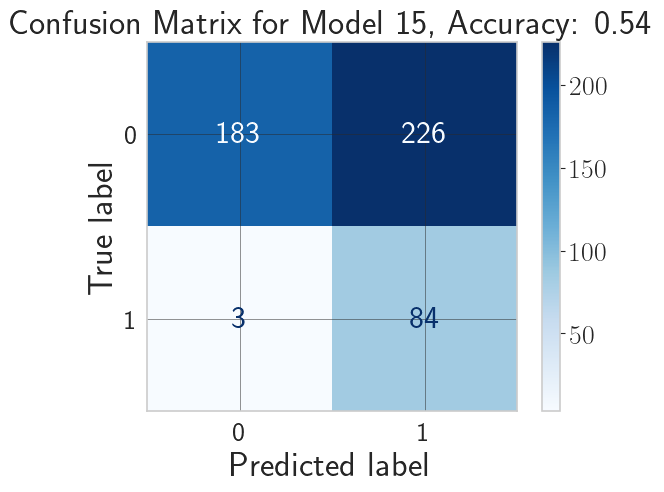

In [8]:
# Confussion matrix for each model
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
for model_num in range(0, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # plot confusion matrix with title corresponding to model number
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)
    # Set title and add accuracy in the title
    disp.ax_.set_title(f'Confusion Matrix for Model {model_num}, Accuracy: {accuracy:.2f}')
    plt.show()

In [9]:
# Lets put the accuracy of all models in a csv file
accuracy_list = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_list.append({'Model': model_num, 'Accuracy': accuracy})
accuracy_df = pd.DataFrame(accuracy_list)
accuracy_df.to_csv('model2_accuracies.csv', index=False)
# Now put the f1 score of all models in a csv file
from sklearn.metrics import f1_score
f1_list = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    f1 = f1_score(y_true, y_pred)
    f1_list.append({'Model': model_num, 'F1_Score': f1})
f1_df = pd.DataFrame(f1_list)
f1_df.to_csv('model2_f1_scores.csv', index=False)

### Logistic Regression with weighted features from base models

Meta-Model Accuracy: 0.8800

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        82
           1       0.80      0.44      0.57        18

    accuracy                           0.88       100
   macro avg       0.84      0.71      0.75       100
weighted avg       0.87      0.88      0.87       100


Model Coefficients (after weighting):
  Model 1: -0.0527
  Model 2: 0.0434
  Model 3: 0.1382
  Model 4: 0.2245
  Model 5: 0.1370
  Model 6: 0.1587
  Model 7: 0.3498
  Model 8: 0.1764
  Model 9: -0.1869
  Model 10: -0.0245
  Model 11: 0.1844
  Model 12: -0.0616
  Model 13: 0.1399
  Model 14: 0.0240
  Model 15: -0.0086


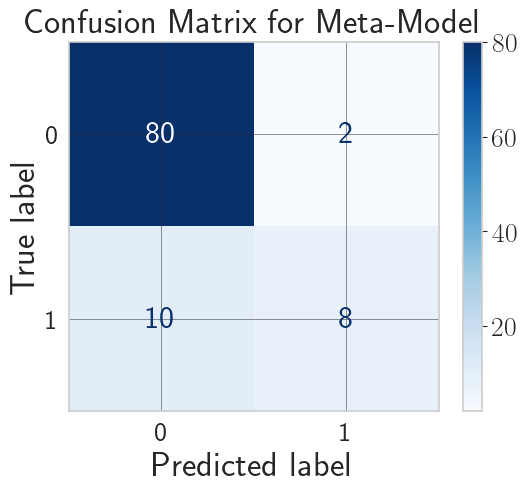

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Prepare data for meta-model
X_meta = df_predictions[[f'pred_{i}' for i in range(1, 16)]].values
y_meta = df_predictions['Sana'].values

# Create weights: higher day number = higher weight
# For example: day 15 has weight 15, day 1 has weight 1
weights = np.array([i for i in range(1, 16)])

# Apply weights to each feature (multiply each column by its weight)
X_meta_weighted = X_meta * weights

# Split data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta_weighted, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)

# Train meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

# Evaluate
y_pred_meta = meta_model.predict(X_test_meta)
print(f"Meta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_meta, y_pred_meta))

# Show feature importance (coefficients)
print("\nModel Coefficients (after weighting):")
for i, coef in enumerate(meta_model.coef_[0], 1):
    print(f"  Model {i}: {coef:.4f}")

# Confusion matrix for meta-model
disp = ConfusionMatrixDisplay.from_predictions(y_test_meta, y_pred_meta, cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix for Meta-Model')
plt.show()

In [11]:
healthy_sample = df_predictions[df_predictions['Sana'] == 1].iloc[randomnumber]
unhealthy_sample = df_predictions[df_predictions['Sana'] == 0].iloc[randomnumber2]

# Lets predict using the meta-model
prediction_healthy = meta_model.predict((healthy_sample[[f'pred_{i}' for i in range(1, 16)]].values * weights).reshape(1, -1))
prediction_unhealthy = meta_model.predict((unhealthy_sample[[f'pred_{i}' for i in range(1, 16)]].values * weights).reshape(1, -1))
print(f'Meta-model prediction for healthy sample (Day {int(healthy_sample["Day"])}): {prediction_healthy[0]}')
print(f'Meta-model prediction for unhealthy sample (Day {int(unhealthy_sample["Day"])}): {prediction_unhealthy[0]}')


Meta-model prediction for healthy sample (Day 12): 1
Meta-model prediction for unhealthy sample (Day 9): 0


### Neural Network

Training Neural Network...
Epoch [10/100], Loss: 0.4264
Epoch [20/100], Loss: 0.3684
Epoch [30/100], Loss: 0.3381
Epoch [40/100], Loss: 0.3314
Epoch [50/100], Loss: 0.3144
Epoch [60/100], Loss: 0.3256
Epoch [70/100], Loss: 0.2865
Epoch [80/100], Loss: 0.3078
Epoch [90/100], Loss: 0.3027
Epoch [100/100], Loss: 0.2850

Neural Network Accuracy: 0.8600

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        82
           1       0.67      0.44      0.53        18

    accuracy                           0.86       100
   macro avg       0.78      0.70      0.73       100
weighted avg       0.85      0.86      0.85       100



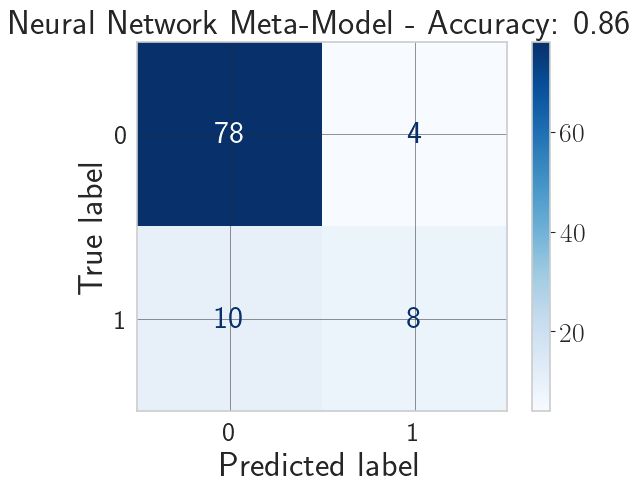

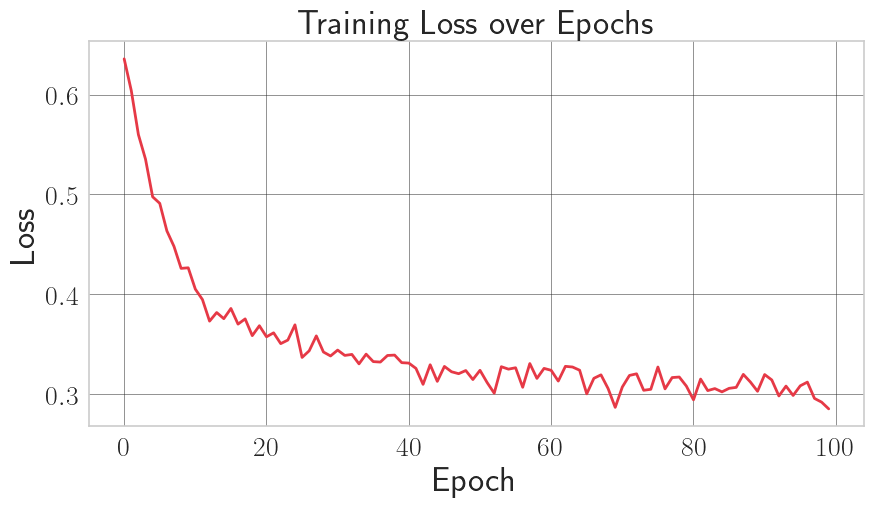


COMPARISON: Neural Network vs Logistic Regression
Neural Network Accuracy: 0.8600
Logistic Regression Accuracy: 0.8800


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define a simple neural network
class MetaClassifier(nn.Module):
    def __init__(self, input_size=15, hidden_size=32):
        super(MetaClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Prepare data for neural network - NO WEIGHTS APPLIED
X_meta = df_predictions[[f'pred_{i}' for i in range(1, 16)]].values
y_meta = df_predictions['Sana'].values

# Split data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_meta)
y_train_tensor = torch.FloatTensor(y_train_meta).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_meta)
y_test_tensor = torch.FloatTensor(y_test_meta).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaClassifier(input_size=15, hidden_size=32).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
print("Training Neural Network...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_pred_proba = model(X_test_tensor).cpu().numpy()
    y_pred_nn = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
accuracy = accuracy_score(y_test_meta, y_pred_nn)
print(f"\nNeural Network Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_meta, y_pred_nn))

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test_meta, y_pred_nn, cmap=plt.cm.Blues)
disp.ax_.set_title(f'Neural Network Meta-Model - Accuracy: {accuracy:.2f}')
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Compare predictions with Logistic Regression
print("\n" + "="*60)
print("COMPARISON: Neural Network vs Logistic Regression")
print("="*60)
print(f"Neural Network Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}")

In [13]:
healthy_sample = df_predictions[df_predictions['Sana'] == 1].iloc[randomnumber]
unhealthy_sample = df_predictions[df_predictions['Sana'] == 0].iloc[randomnumber2]
# Prepare data for Neural Network prediction (no weights)
X_healthy_nn = torch.FloatTensor(healthy_sample[[f'pred_{i}' for i in range(1, 16)]].values).unsqueeze(0).to(device)
X_unhealthy_nn = torch.FloatTensor(unhealthy_sample[[f'pred_{i}' for i in range(1, 16)]].values).unsqueeze(0).to(device)

# Make predictions with Neural Network
model.eval()
with torch.no_grad():
    prediction_healthy_nn = model(X_healthy_nn).cpu().numpy()[0][0]
    prediction_unhealthy_nn = model(X_unhealthy_nn).cpu().numpy()[0][0]

# Convert probabilities to class predictions
prediction_healthy = (prediction_healthy_nn > 0.5).astype(int)
prediction_unhealthy = (prediction_unhealthy_nn > 0.5).astype(int)

print(f'Neural Network prediction for healthy sample (Day {int(healthy_sample["Day"])}): {prediction_healthy} ')
print(f'Neural Network prediction for unhealthy sample (Day {int(unhealthy_sample["Day"])}): {prediction_unhealthy}')


Neural Network prediction for healthy sample (Day 12): 1 
Neural Network prediction for unhealthy sample (Day 9): 0


## Logistic Regression weighted by accuracy

Model 1 accuracy: 0.6190
Model 2 accuracy: 0.8145
Model 3 accuracy: 0.8125
Model 4 accuracy: 0.6149
Model 5 accuracy: 0.7560
Model 6 accuracy: 0.5948
Model 7 accuracy: 0.8246
Model 8 accuracy: 0.5786
Model 9 accuracy: 0.6996
Model 10 accuracy: 0.7621
Model 11 accuracy: 0.7077
Model 12 accuracy: 0.5827
Model 13 accuracy: 0.6976
Model 14 accuracy: 0.5806
Model 15 accuracy: 0.5383

Performance weights: [0.61895161 0.81451613 0.8125     0.61491935 0.75604839 0.59475806
 0.82459677 0.57862903 0.69959677 0.76209677 0.70766129 0.58266129
 0.69758065 0.58064516 0.53830645]
Min weight: 0.5383, Max weight: 0.8246

Meta-Model Accuracy: 0.8600

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        82
           1       0.75      0.33      0.46        18

    accuracy                           0.86       100
   macro avg       0.81      0.65      0.69       100
weighted avg       0.85      0.86      0.84       100


Model Co

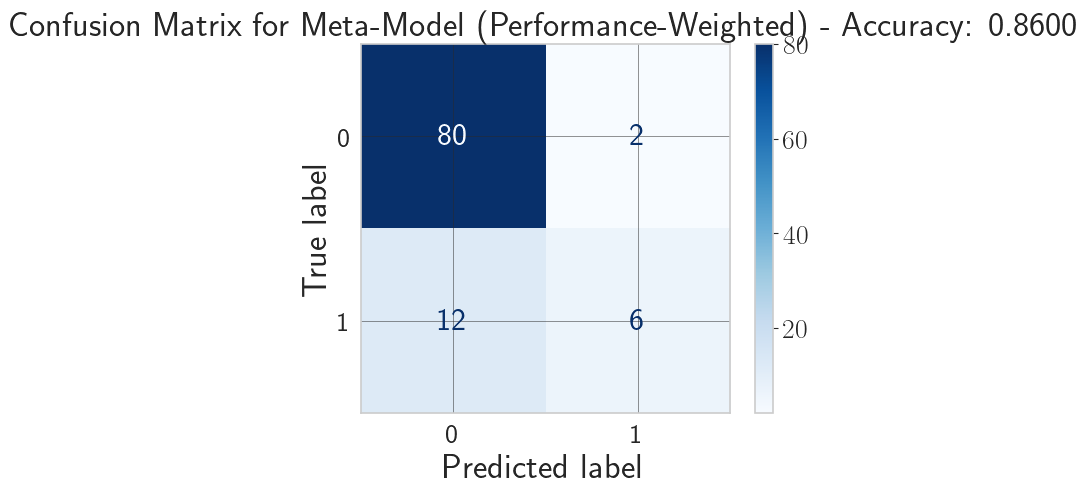

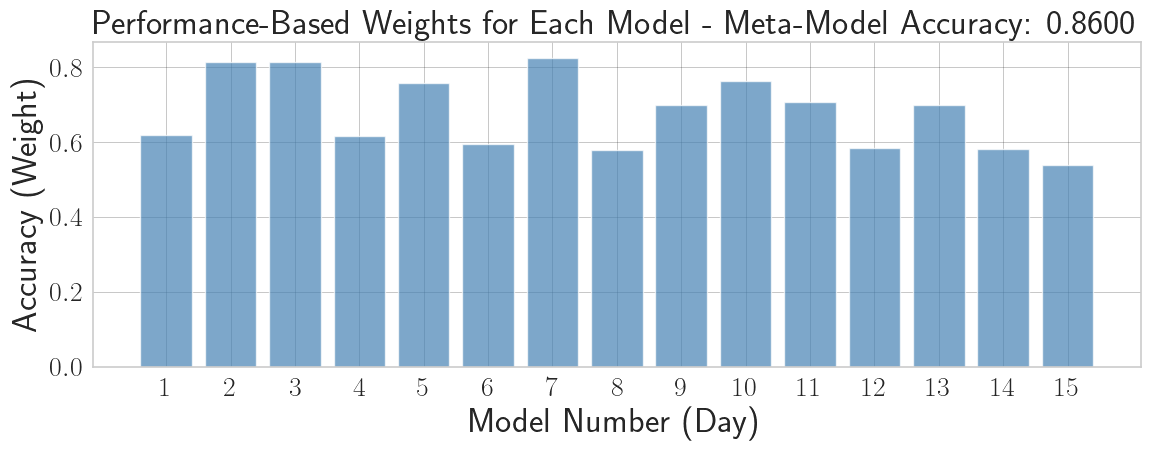

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Prepare data for meta-model
X_meta = df_predictions[[f'pred_{i}' for i in range(1, 16)]].values
y_meta = df_predictions['Sana'].values

# Calculate performance-based weights using accuracy of each model
performance_weights = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    accuracy = accuracy_score(y_true, y_pred)
    performance_weights.append(accuracy)
    print(f"Model {model_num} accuracy: {accuracy:.4f}")

# Convert to numpy array
weights = np.array(performance_weights)
print(f"\nPerformance weights: {weights}")
print(f"Min weight: {weights.min():.4f}, Max weight: {weights.max():.4f}")

# Apply weights to each feature (multiply each column by its accuracy weight)
X_meta_weighted = X_meta * weights

# Split data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta_weighted, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)

# Train meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

# Evaluate
y_pred_meta = meta_model.predict(X_test_meta)
print(f"\nMeta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_meta, y_pred_meta))

# Show feature importance (coefficients after weighting)
print("\nModel Coefficients (after performance weighting):")
for i, coef in enumerate(meta_model.coef_[0], 1):
    print(f"  Model {i} (weight={weights[i-1]:.4f}): coef={coef:.4f}")

# Confusion matrix for meta-model
disp = ConfusionMatrixDisplay.from_predictions(y_test_meta, y_pred_meta, cmap=plt.cm.Blues)
disp.ax_.set_title(f'Confusion Matrix for Meta-Model (Performance-Weighted) - Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}')
plt.show()

# Visualize the performance weights
plt.figure(figsize=(12, 5))
plt.bar(range(1, 16), weights, color='steelblue', alpha=0.7)
plt.xlabel('Model Number (Day)')
plt.ylabel('Accuracy (Weight)')
plt.title(f'Performance-Based Weights for Each Model - Meta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}')
plt.xticks(range(1, 16))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()